#### Multiobjective transportation problem

1. A company owns two plants, which produce product A and
   deliver it to three final markets. Given the data below:

2. Formulate the objective function and constraints of an LP
   model and solve it with GAMS to determine the mass flow
   rates that minimise the total transportation cost.

3. Calculate 5 points of the Pareto front (total cost vs
   global warming potential) and identify the best solution
   according to your preferences.

   Hint: calculate first the ideal and nadir points, and then
   define the epsilon values on the global warming objective by
   dividing its max-min interval into equal sub-intervals. The
   model is then solved minimising the total cost for each such
   epsilon value.

In [28]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd

transport_cost = ConcreteModel()

plants=['liverpool', 'brighton']
markets=['cambridge','london','manchester']


In [29]:
capacity=pd.DataFrame(index=plants)
capacity['capacity']=[750,600]

demand=pd.DataFrame(index=markets)
demand['demand']=[225,500,275]

index=pd.MultiIndex.from_product([plants, markets])
cost_gwp = pd.DataFrame({'cost': [450,600,125,350,275,700],
                       'gwp': [1100,1400,450,1700,1550,2400]})
cost_gwp=cost_gwp.set_index(index)
print(cost_gwp['cost'])

liverpool  cambridge     450
           london        600
           manchester    125
brighton   cambridge     350
           london        275
           manchester    700
Name: cost, dtype: int64


In [30]:
transport_cost.plants=Set(initialize=plants)
transport_cost.markets=Set(initialize=markets)

In [31]:
transport_cost.X=Var(plants,markets, domain=NonNegativeReals)
transport_cost.X.pprint()

X : Size=6, Index=X_index
    Key                         : Lower : Value : Upper : Fixed : Stale : Domain
      ('brighton', 'cambridge') :     0 :  None :  None : False :  True : NonNegativeReals
         ('brighton', 'london') :     0 :  None :  None : False :  True : NonNegativeReals
     ('brighton', 'manchester') :     0 :  None :  None : False :  True : NonNegativeReals
     ('liverpool', 'cambridge') :     0 :  None :  None : False :  True : NonNegativeReals
        ('liverpool', 'london') :     0 :  None :  None : False :  True : NonNegativeReals
    ('liverpool', 'manchester') :     0 :  None :  None : False :  True : NonNegativeReals


#### Primero resolvemos el problema de mínimo coste

In [32]:
# objective 
def cost(modelo):
    a=0
    for p in plants:
            a += sum(cost_gwp['cost'][p,m]*modelo.X[p,m] for m in markets)
    return a
                    
transport_cost.objective = Objective(rule = cost, sense=minimize)
# constraints
transport_cost.constraints = ConstraintList()
for p in plants:
    transport_cost.constraints.add(sum(transport_cost.X[p,m] for m in markets)<=capacity['capacity'][p])
for m in markets:    
    transport_cost.constraints.add(sum(transport_cost.X[p,m] for p in plants)>=demand['demand'][m])
results_cost = SolverFactory('glpk').solve(transport_cost).write()
transport_cost.pprint()
zcl=value(transport_cost.objective)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 263125.0
  Upper bound: 263125.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 7
  Number of nonzeros: 13
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.028914451599121094
# ----------------------------------------------------------
#   Solution Information
# -----------------------------

#### Siguiente modelo transport_gwp para minimizar el gwp. Con esto ya tenemos los mínimos de los dos objetivos

In [33]:
transport_gwp = ConcreteModel()
transport_gwp.plants=Set(initialize=plants)
transport_gwp.markets=Set(initialize=markets)
transport_gwp.X=Var(plants,markets, domain=NonNegativeReals)
# objective 
def gwp(modelo):
    a=0
    for p in plants:
            a += sum(cost_gwp['gwp'][p,m]*modelo.X[p,m] for m in markets)
    return a
                    
transport_gwp.objective = Objective(rule = gwp, sense=minimize)
# constraints
transport_gwp.constraints = ConstraintList()
for p in plants:
    transport_gwp.constraints.add(sum(transport_gwp.X[p,m] for m in markets)<=capacity['capacity'][p])
for m in markets:    
    transport_gwp.constraints.add(sum(transport_gwp.X[p,m] for p in plants)>=demand['demand'][m])

results_gwp = SolverFactory('glpk').solve(transport_gwp).write()
transport_gwp.pprint()
zgl=value(transport_gwp.objective)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1108750.0
  Upper bound: 1108750.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 7
  Number of nonzeros: 13
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.031914710998535156
# ----------------------------------------------------------
#   Solution Information
# ---------------------------

#### El siguiente paso será calcular el punto nadir. Para ello minimizaremos el coste imponiendo como constraint que el gwp sea menor o igual que el valor menor de gwp calculado hasta ahora (zgl). Resolvemos transport_cost_epsgwp


In [34]:
transport_cost_epsgwp = ConcreteModel()
transport_cost_epsgwp.plants=Set(initialize=plants)
transport_cost_epsgwp.markets=Set(initialize=markets)
transport_cost_epsgwp.X=Var(plants,markets, domain=NonNegativeReals)
def gwp_cost(modelo):
    a=0
    for p in plants:
            a += sum(cost_gwp['gwp'][p,m]*modelo.X[p,m] for m in markets)
    return a<=zgl
epsilon=zgl 
transport_cost_epsgwp.objective = Objective(rule = cost, sense=minimize)
# constraints
transport_cost_epsgwp.constraints = ConstraintList()
for p in plants:
    transport_cost_epsgwp.constraints.add(sum(transport_cost_epsgwp.X[p,m] for m in markets)<=capacity['capacity'][p])

for m in markets:    
    transport_cost_epsgwp.constraints.add(sum(transport_cost_epsgwp.X[p,m] for p in plants)>=demand['demand'][m])

transport_cost_epsgwp.gwp=Constraint(rule=gwp_cost)
 
results_cost_epsgwp = SolverFactory('glpk').solve(transport_cost_epsgwp).write()
transport_cost_epsgwp.pprint()
zcu=value(transport_cost_epsgwp.objective)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 354375.0
  Upper bound: 354375.0
  Number of objectives: 1
  Number of constraints: 7
  Number of variables: 7
  Number of nonzeros: 19
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.02692699432373047
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

#### Con lo anterior, tendríamos el valor del menor coste para el caso de impooner el mínimo valor de gwp. Ahora haremos lo contrario: calculamos el menor gwp, imponiendo el valor mínimo del coste (zcl). Resolvemos transport_gwp_epscost

In [35]:
def transport_gwp_epscostf(epsilon):
    transport_gwp_epscost = ConcreteModel()
    transport_gwp_epscost.plants=Set(initialize=plants)
    transport_gwp_epscost.markets=Set(initialize=markets)
    transport_gwp_epscost.X=Var(plants,markets, domain=NonNegativeReals)
    def cost_gwpf(modelo):
        a=0
        for p in plants:
                a += sum(cost_gwp['cost'][p,m]*modelo.X[p,m] for m in markets)
        return a<=epsilon

    transport_gwp_epscost.objective = Objective(rule=gwp, sense=minimize)

    # constraints
    transport_gwp_epscost.constraints = ConstraintList()
    for p in plants:
        transport_gwp_epscost.constraints.add(sum(transport_gwp_epscost.X[p,m] for m in markets)<=capacity['capacity'][p])

    for m in markets:    
        transport_gwp_epscost.constraints.add(sum(transport_gwp_epscost.X[p,m] for p in plants)>=demand['demand'][m])

    transport_gwp_epscost.costa=Constraint(rule=cost_gwpf)
 
    results_gwp_epscost = SolverFactory('glpk').solve(transport_gwp_epscost)
    transport_gwp_epscost.pprint()
    zgg=value(transport_gwp_epscost.objective)
    zcc=value(transport_gwp_epscost.costa)
      
    return zgg,zcc
   
    
epsilon=zcl
zgu=transport_gwp_epscostf(epsilon)[0]


6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

#### Con esto tenemos los upper y lower bound de los objetivos individuales

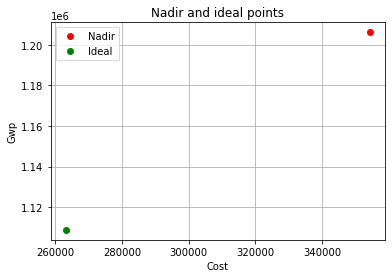

In [36]:
plt.plot(zcu,zgu,'ro');
plt.plot(zcl,zgl,'go');
plt.title('Nadir and ideal points');
plt.grid(True);  
plt.ylabel("Gwp");
plt.xlabel("Cost");
plt.legend(['Nadir','Ideal'])
plt.show()

In [37]:
# pareto points
n=10
zg_l = []
zc_l = []
eps ={}
for l in range(n+1):
    epsilon=zcl+(zcu-zcl)/n*l
    eps[l]=epsilon
    zg_l.append(transport_gwp_epscostf(epsilon)[0])
    zc_l.append(transport_gwp_epscostf(epsilon)[1])

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

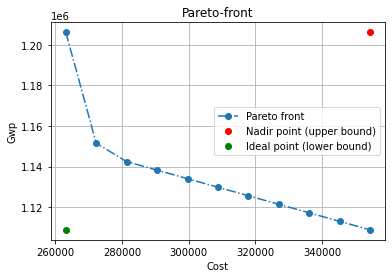

In [38]:
plt.plot(zc_l,zg_l,'o-.');
plt.plot(zcu,zgu,'ro');
plt.plot(zcl,zgl,'go');
plt.title('Pareto-front');
plt.grid(True);  
plt.ylabel("Gwp");
plt.xlabel("Cost");
plt.legend(['Pareto front','Nadir point (upper bound)','Ideal point (lower bound)'])
plt.show()